In [1]:
import sys
sys.path.insert(0, './..')
sys.path.insert(0, '../data')

import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

import plotly.graph_objects as go
import matplotlib.pyplot as plt
import proplot as pplt
import numpy as np
import plots as pl
import tqdm
import torch
from torchvision import datasets, transforms
from robustness.datasets import CIFAR
import dill
import pickle5 as pickle
from utils import dev, load_data, classification, make_orth_basis, orth_check, get_dist_dec

from models import eval, model
from matplotlib.ticker import FormatStrFormatter
import tqdm
from scipy.stats import kstest, multivariate_normal
import seaborn as sns
import pandas as pd
titlesize = 10
fontsize = 8
cm = 1/2.54
figwidth = 13.968*cm
dpi = 600
params = {'legend.fontsize': fontsize,
          'legend.title_fontsize': fontsize,
          'font.family': 'serif',
          'axes.labelsize': fontsize,
          'axes.titlesize':titlesize,
          'xtick.labelsize':fontsize,
          'ytick.labelsize':fontsize}
plt.rcParams.update(params)

pplt.rc.update(params)

def tab_name_to_hex(tab): 
    conv_table = {
        "tab:blue": "#1f77b4",
        "tab:orange": "#ff7f0e",
        "tab:green": "#2ca02c",
        "tab:red": "#d62728",
        "tab:purple": "#9467bd",
        "tab:brown": "#8c564b",
        "tab:pink": "#e377c2",
        "tab:gray": "#7f7f7f",
        "tab:grey": "#7f7f7f",
        "tab:olive": "#bcbd22",
        "tab:cyan": "#17becf",
    }
    return conv_table[tab.lower()]

plot_colors = [tab_name_to_hex('tab:blue'), 
               tab_name_to_hex('tab:red'), 
               tab_name_to_hex('tab:green'), 
               tab_name_to_hex('tab:orange'), 
               tab_name_to_hex('tab:purple'), 
               tab_name_to_hex('tab:brown'), 
               tab_name_to_hex('tab:pink'), 
               tab_name_to_hex('tab:gray'), 
               tab_name_to_hex('tab:olive'), 
               tab_name_to_hex('tab:cyan')]               

In [2]:
def plot_boxplot(pert_lengths, n=10, labels=None, showmeans=False, ax=None):
    n = np.minimum(n, pert_lengths[0].shape[1])
    pert_lengths = [p[:,:n] for p in pert_lengths]
    colors = plot_colors
    l = []
    offset = [-.4,.4]
    plt.sca(ax)

    for i, pl in enumerate(pert_lengths):
        boxprops = dict(color=colors[i], linewidth=.5, alpha=1)
        whiskerprops = dict(color=colors[i], alpha=0.7)
        capprops = dict(color=colors[i], alpha=0.7)
        medianprops = dict(linestyle='--', linewidth=.5, color=colors[i])
        meanprops = dict(linestyle='-', linewidth=.5, color=colors[i])


        if not labels is None:
            l.append(mpatches.Patch(color=colors[i], label=labels[i]))

        pl[pl==0] = np.nan
        mask = ~np.isnan(pl)
        filtered_data = [d[m] for d, m in zip(pl.T, mask.T)]
        plt.boxplot(filtered_data, positions=np.array(range(len(filtered_data)))*len(pert_lengths) + offset[i], sym='', widths=0.6,
                   whis=[10,90], showfliers=False, meanline=showmeans, showmeans=showmeans, boxprops=boxprops, 
                   whiskerprops=whiskerprops, capprops=capprops, meanprops=meanprops,  medianprops=medianprops)
#     ax.set_title('Perturbation length of first ' + str(n) + ' adversarial directions')
    ax.set_ylabel('adversarial vector length')
    ax.set_xticks(np.arange(0,n*len(pert_lengths),len(pert_lengths)))
    ax.set_xticklabels(np.arange(1,n+1))
    ax.tick_params(axis='x', which='minor', bottom=False)
    ax.xaxis.grid(False)
    if not (labels is None):
        leg = ax.legend(handles=l, frameon=False)
        leg.get_frame().set_linewidth(0.0)
    return 

# Load models

In [3]:
# load models
model_natural = model.madry_diff()
model_robust = model.madry_diff()
model_natural.load_state_dict(torch.load('../models/mnist_models/natural_0.pt', map_location=torch.device(dev())))
model_robust.load_state_dict(torch.load('../models/mnist_models/robust_0.pt', map_location=torch.device(dev())))
model_natural.to(dev())
model_robust.to(dev())
model_natural.eval()
model_robust.eval()

madry_diff(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxPool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxPool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
  (elu): ELU(alpha=1.0)
)

# Load data

In [4]:
# load data
data= np.load('../data/MNIST_runs/natural_0.npy', allow_pickle=True).item()
advs = data['advs']
pert_lengths = data['pert_lengths']
classes = data['adv_class']
dirs = data['dirs']
images = data['images']
labels = data['labels']

data_madry = np.load('../data/MNIST_runs/robust_0.npy', allow_pickle=True).item()
advs_madry = data_madry['advs']
pert_lengths_madry = data_madry['pert_lengths']
classes_madry = data_madry['adv_class']
dirs_madry = data_madry['dirs']
images_madry = data_madry['images']
labels_madry = data_madry['labels']

n_dims=8
p_robust = pert_lengths_madry[np.invert(np.isnan(pert_lengths_madry)).sum(-1)>=n_dims,:n_dims]
p_natural = pert_lengths[np.invert(np.isnan(pert_lengths)).sum(-1)>=n_dims,:n_dims]


data= np.load('../data/MNIST_runs/dists_to_bnd_natural.npy', allow_pickle=True).item()
dists_natural = data['dists']
angles_natural = data['angles']
largest_vecs_natural = data['largest_vecs']

data= np.load('../data/MNIST_runs/dists_to_bnd_robust.npy', allow_pickle=True).item()
dists_robust = data['dists']
angles_robust = data['angles']
largest_vecs_robust = data['largest_vecs']            
              
dists_natural[dists_natural==0]=np.nan
dists_robust[dists_robust==0]=np.nan

angles_natural[np.isnan(dists_natural)]=np.nan
angles_robust[np.isnan(dists_robust)]=np.nan



# Compare seeds

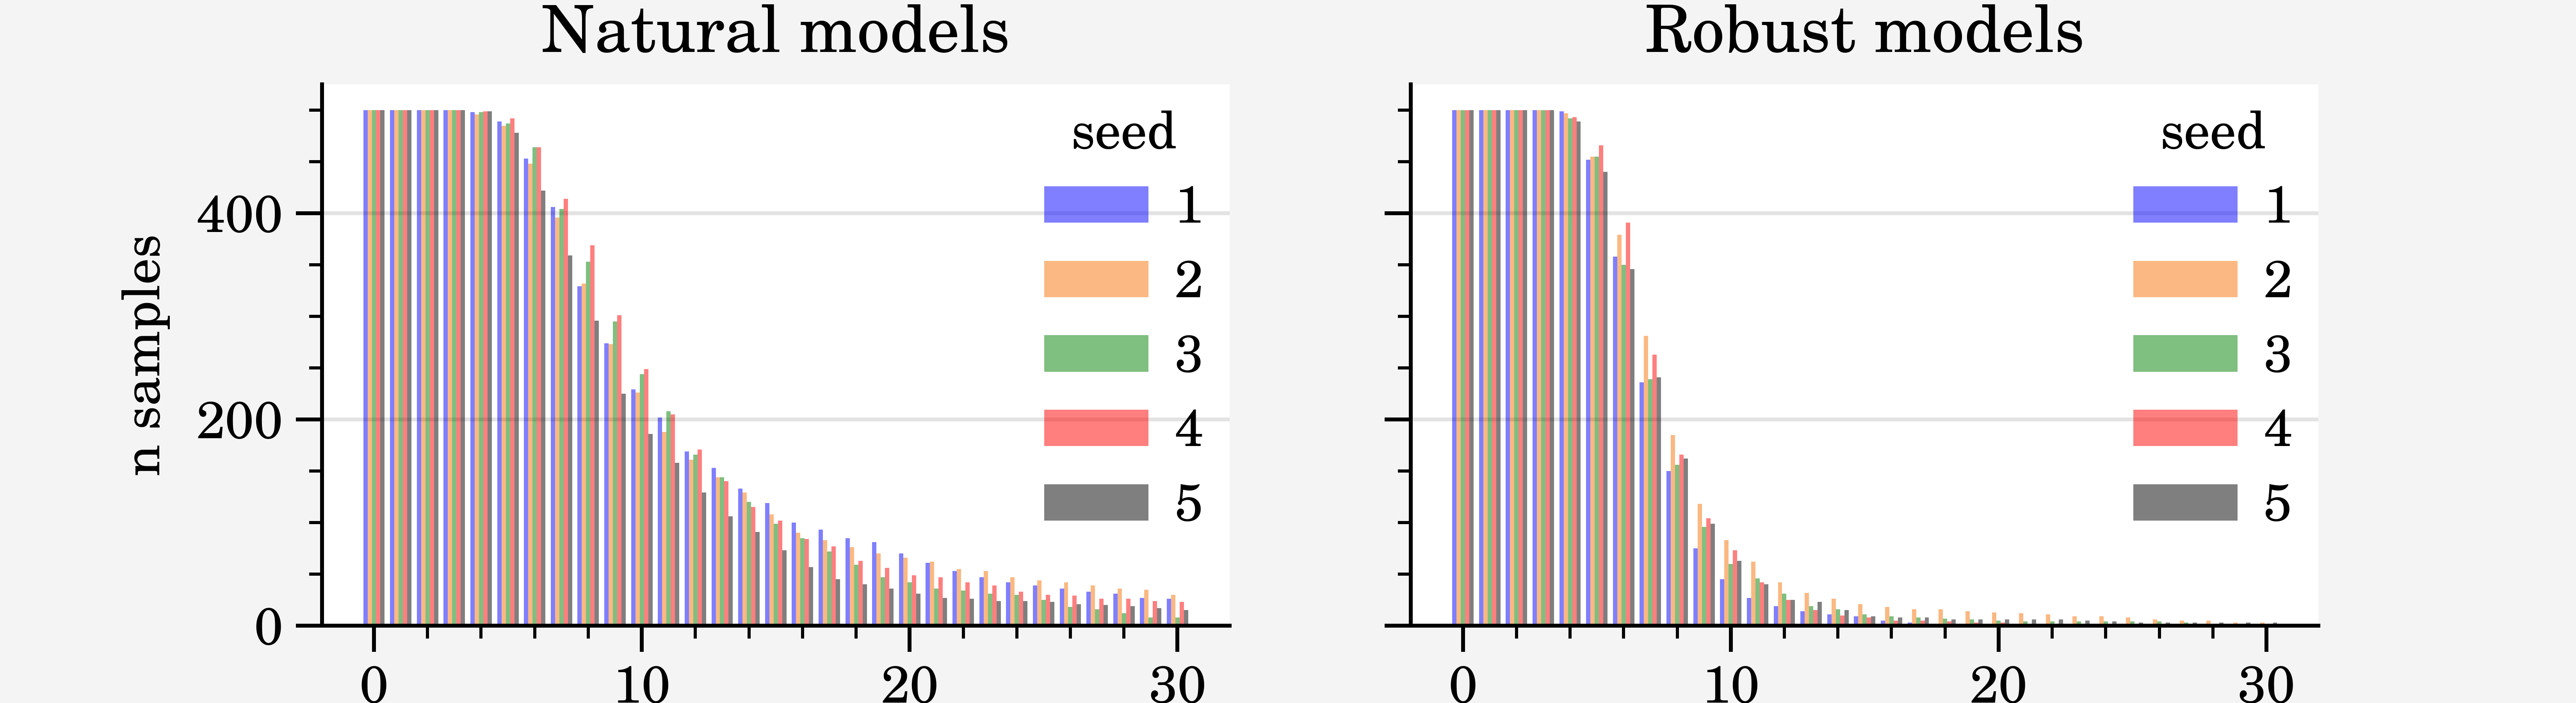

In [14]:
fig, ax = plt.subplots(1,2, figsize=(figwidth,1.5), dpi=dpi, sharey=True)

data = np.load('../data/MNIST_runs/natural_0.npy', allow_pickle=True).item()
images = data['images']
labels = data['labels']
n_advs = np.zeros((5,len(images)))
for i,model_id in enumerate([0,1,2,3,4]):
    # load data
    data = np.load('../data/MNIST_runs/natural_'+str(model_id)+'.npy', allow_pickle=True).item()
    advs = data['advs']
    pert_lengths = data['pert_lengths']
    classes = data['adv_class']
    dirs = data['dirs']
    images = data['images']
    labels = data['labels']
    pert_lengths = data['pert_lengths']
    n_advs[i] = np.invert(np.isnan(pert_lengths)).sum(1)

ax[0].hist(n_advs.T, alpha=0.5, bins=31, range=(-0.5,30.5), cumulative=-1, label=['1', '2', '3', '4', '5'], color=['blue', 'orange', 'green', 'red', 'black'])
ax[0].legend(title='seed', frameon=False, fontsize=fontsize)
ax[0].set_xlabel('found dimensions', fontsize=fontsize)
ax[0].set_ylabel('n samples', fontsize=fontsize)
ax[0].xaxis.grid(False)
ax[0].set_title('Natural models')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

n_advs = np.zeros((5,len(images)))
for i,model_id in enumerate([0,1,2,3,4]):
    # load data
    data = np.load('../data/MNIST_runs/robust_'+str(model_id)+'.npy', allow_pickle=True).item()
    advs = data['advs']
    pert_lengths = data['pert_lengths']
    classes = data['adv_class']
    dirs = data['dirs']
    images = data['images']
    labels = data['labels']
    pert_lengths = data['pert_lengths']
    n_advs[i] = np.invert(np.isnan(pert_lengths)).sum(1)

ax[1].hist(n_advs.T, alpha=0.5, bins=31, range=(-0.5,30.5), cumulative=-1, label=['1', '2', '3', '4', '5'], color=['blue', 'orange', 'green', 'red', 'black'])
ax[1].legend(title='seed', frameon=False, fontsize=fontsize)
ax[1].set_xlabel('found dimensions', fontsize=fontsize)
ax[1].xaxis.grid(False)
ax[1].set_title('Robust models')
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

plt.show()
fig.savefig('../figures/seeds.pdf', dpi=dpi, transparent=True, bbox_inches="tight", pad_inches=0.01)

# Plot grid of adversarial examples

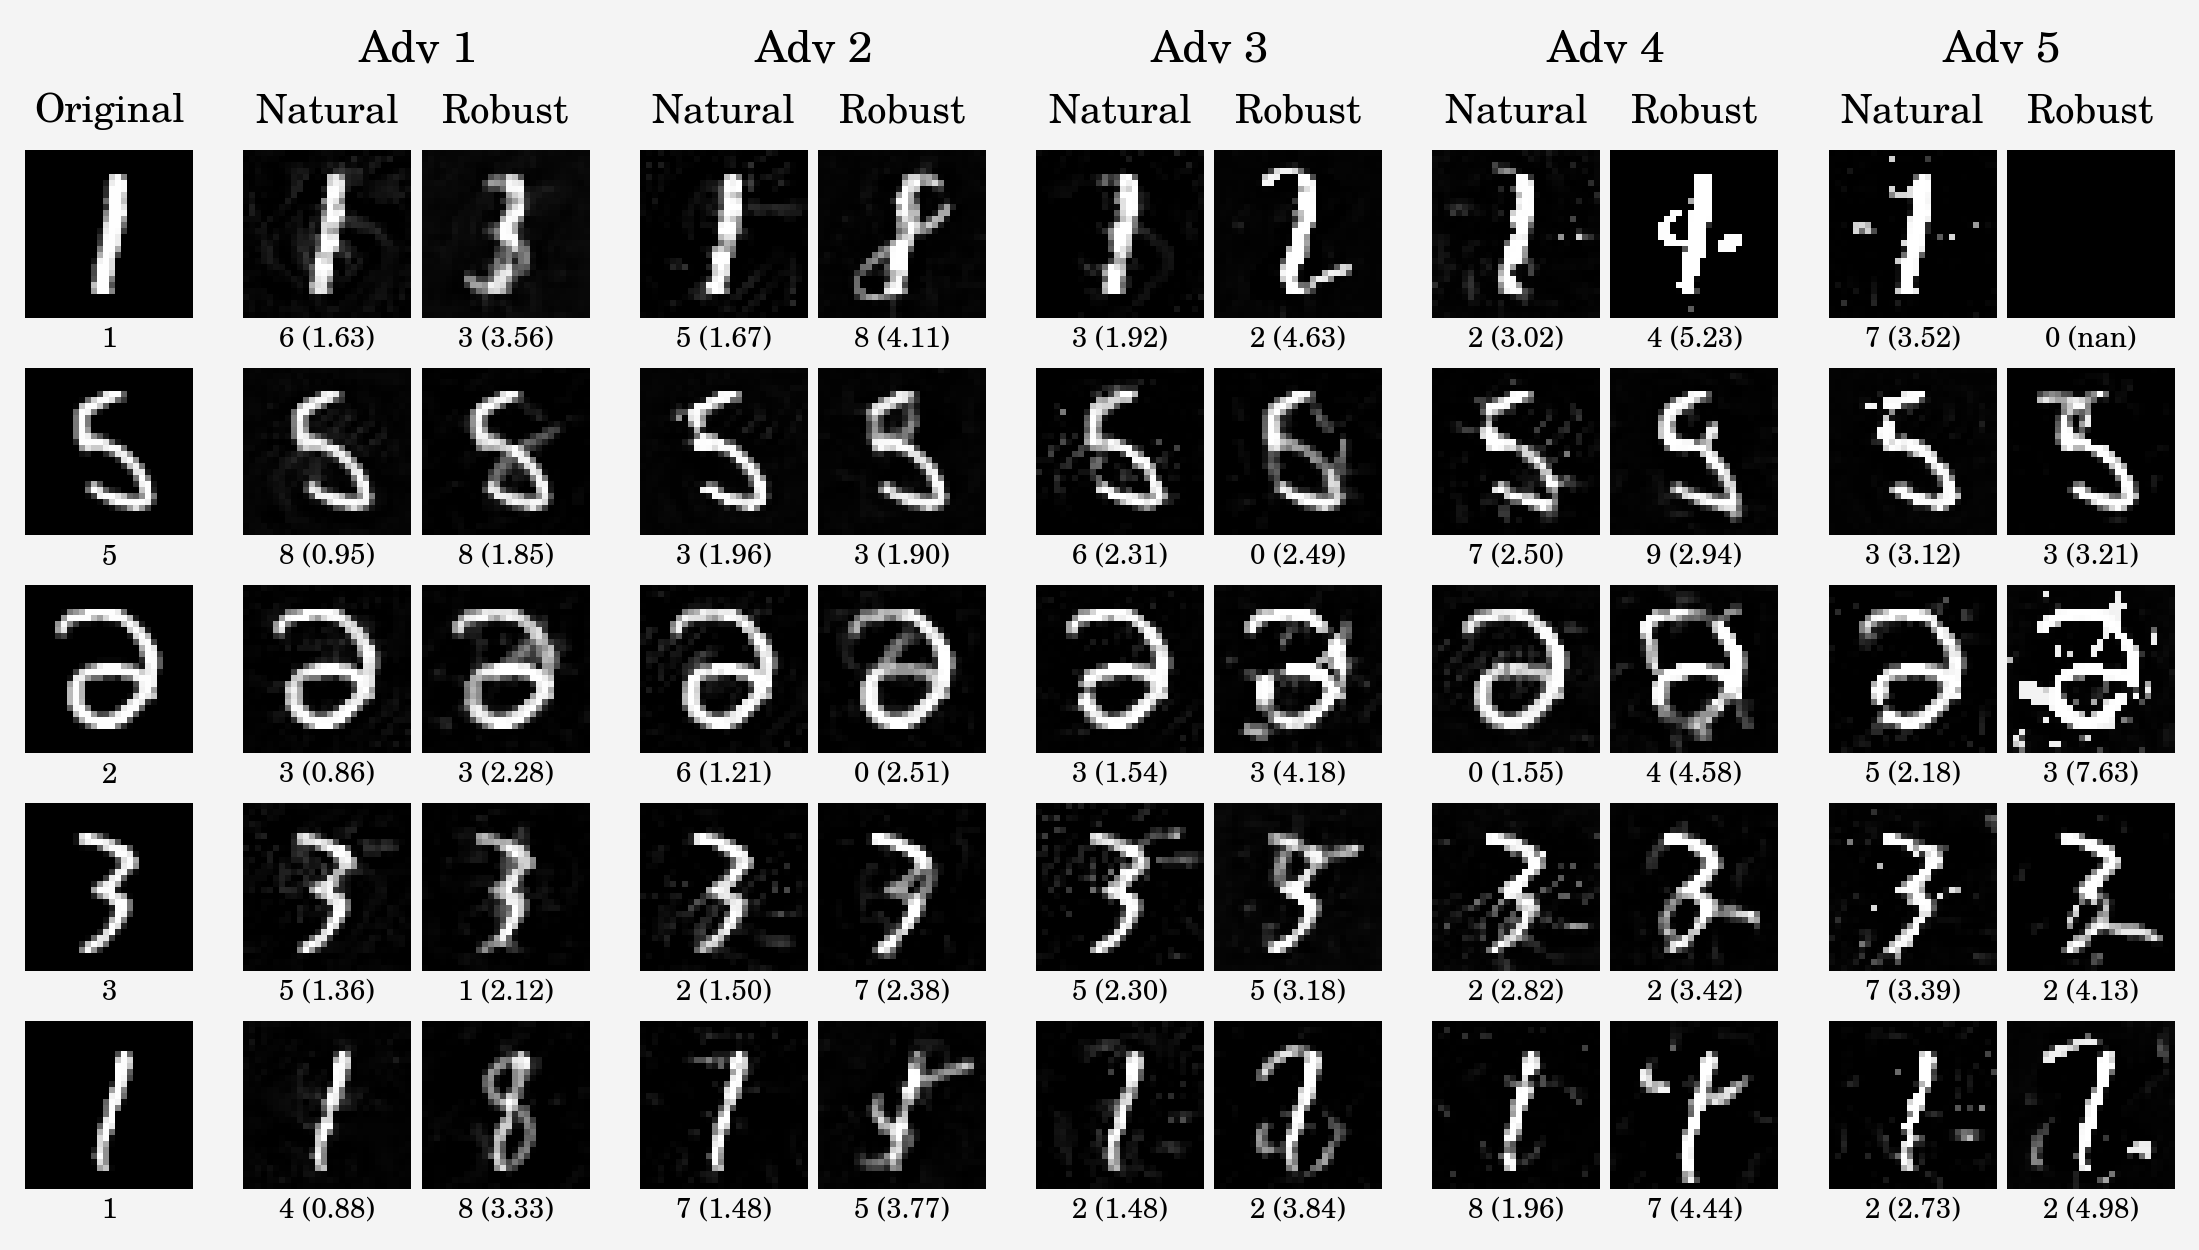

In [19]:
array = [
    range(1,12),
    range(12,23),
    range(23,34),
    range(34,45),
    range(45,56)
]
hspace = [1,]*4
wspace =  [1, 0.2,]*5
n_images = 5

fig, ax = pplt.subplots(array, sharey=False, sharex=False, dpi=200,
                          wspace=wspace, hspace=hspace, figwidth=figwidth, top=3)

# img_idcs = [81, 20, 1 ,77, 63]
img_idcs = np.random.choice(np.arange(500), size=n_images, replace=False)

ax[0].set_title('Original', fontsize=7)
ax_idx=0
for i, img_n in enumerate(img_idcs):
    ax[ax_idx].imshow(images[img_n,0], cmap='gray', vmin=0, vmax=1)
    ax[ax_idx].set_xlabel(str(int(labels[img_n])), fontsize=5)
    ax[ax_idx].xaxis.set_label_coords(0.5, -0.05)
    ax[ax_idx].set_xticks([])
    ax[ax_idx].set_yticks([])
    for pos in ['top', 'left', 'right', 'bottom']:
        ax[ax_idx].spines[pos].set_visible(False)

    ax_idx+=1
    for j in range(n_images):
        ax[ax_idx].imshow(advs[img_n,j].reshape(28,28), cmap='gray', vmin=0, vmax=1)
        for pos in ['top', 'left', 'right', 'bottom']:
            ax[ax_idx].spines[pos].set_visible(False)
        ax[ax_idx].set_xticks([])
        ax[ax_idx].set_yticks([])
        ax[ax_idx].set_xlabel(str(int(classes[img_n,j]))+ ' (%.2f)' % (pert_lengths[img_n, j]), fontsize=5)
        ax[ax_idx].xaxis.set_label_coords(0.5, -0.05)
        if i == 0:
            ax[ax_idx].set_title('Natural', fontsize=7)
        
        ax_idx+=1
        if i == 0:
            ax[ax_idx].set_title('Robust', fontsize=7)
        ax[ax_idx].imshow(advs_madry[img_n,j].reshape(28,28), cmap='gray', vmin=0, vmax=1)
        ax[ax_idx].set_xticks([])
        ax[ax_idx].set_yticks([])
        for pos in ['top', 'left', 'right', 'bottom']:
            ax[ax_idx].spines[pos].set_visible(False)
        ax[ax_idx].set_xlabel(str(int(classes_madry[img_n,j]))+ ' (%.2f)' % (pert_lengths_madry[img_n, j]), fontsize=5)
        ax[ax_idx].xaxis.set_label_coords(0.5, -0.05)
        ax_idx+=1

# the first two arguments to figtext are x and y coordinates in the figure system (0 to 1)
plt.figtext(.19,.96,"Adv 1", va="center", ha="center", size=8)
plt.figtext(.37,.96,"Adv 2", va="center", ha="center", size=8)
plt.figtext(.55,.96,"Adv 3", va="center", ha="center", size=8)
plt.figtext(.73,.96,"Adv 4", va="center", ha="center", size=8)
plt.figtext(.91,.96,"Adv 5", va="center", ha="center", size=8)

fig.savefig('../figures/mnist_examples.pdf', dpi=dpi, transparent=True, bbox_inches="tight", pad_inches=0.01)


# Perturbation Length comparison

In [10]:
epsilons = np.arange(0,6,.001)
n_dims_natural = np.zeros((len(epsilons),len(p_natural)))
n_dims_robust = np.zeros((len(epsilons),len(p_robust)))
for i, e in enumerate(epsilons):
    n_dims_natural[i] = (p_natural < e).sum(-1)
    n_dims_robust[i] = (p_robust < e).sum(-1)

percentiles_natural = np.percentile(n_dims_natural, [10,90], axis=-1)
means_natural = np.mean(n_dims_natural,axis=-1)
errors_natural = percentiles_natural.copy()
errors_natural[0] = means_natural-percentiles_natural[0]
errors_natural[1] = percentiles_natural[1] - means_natural

percentiles_robust = np.percentile(n_dims_robust, [10,90], axis=-1)
means_robust = np.mean(n_dims_robust,axis=-1)
errors_robust = percentiles_robust.copy()
errors_robust[0] = means_robust-percentiles_robust[0]
errors_robust[1] = percentiles_robust[1] - means_robust

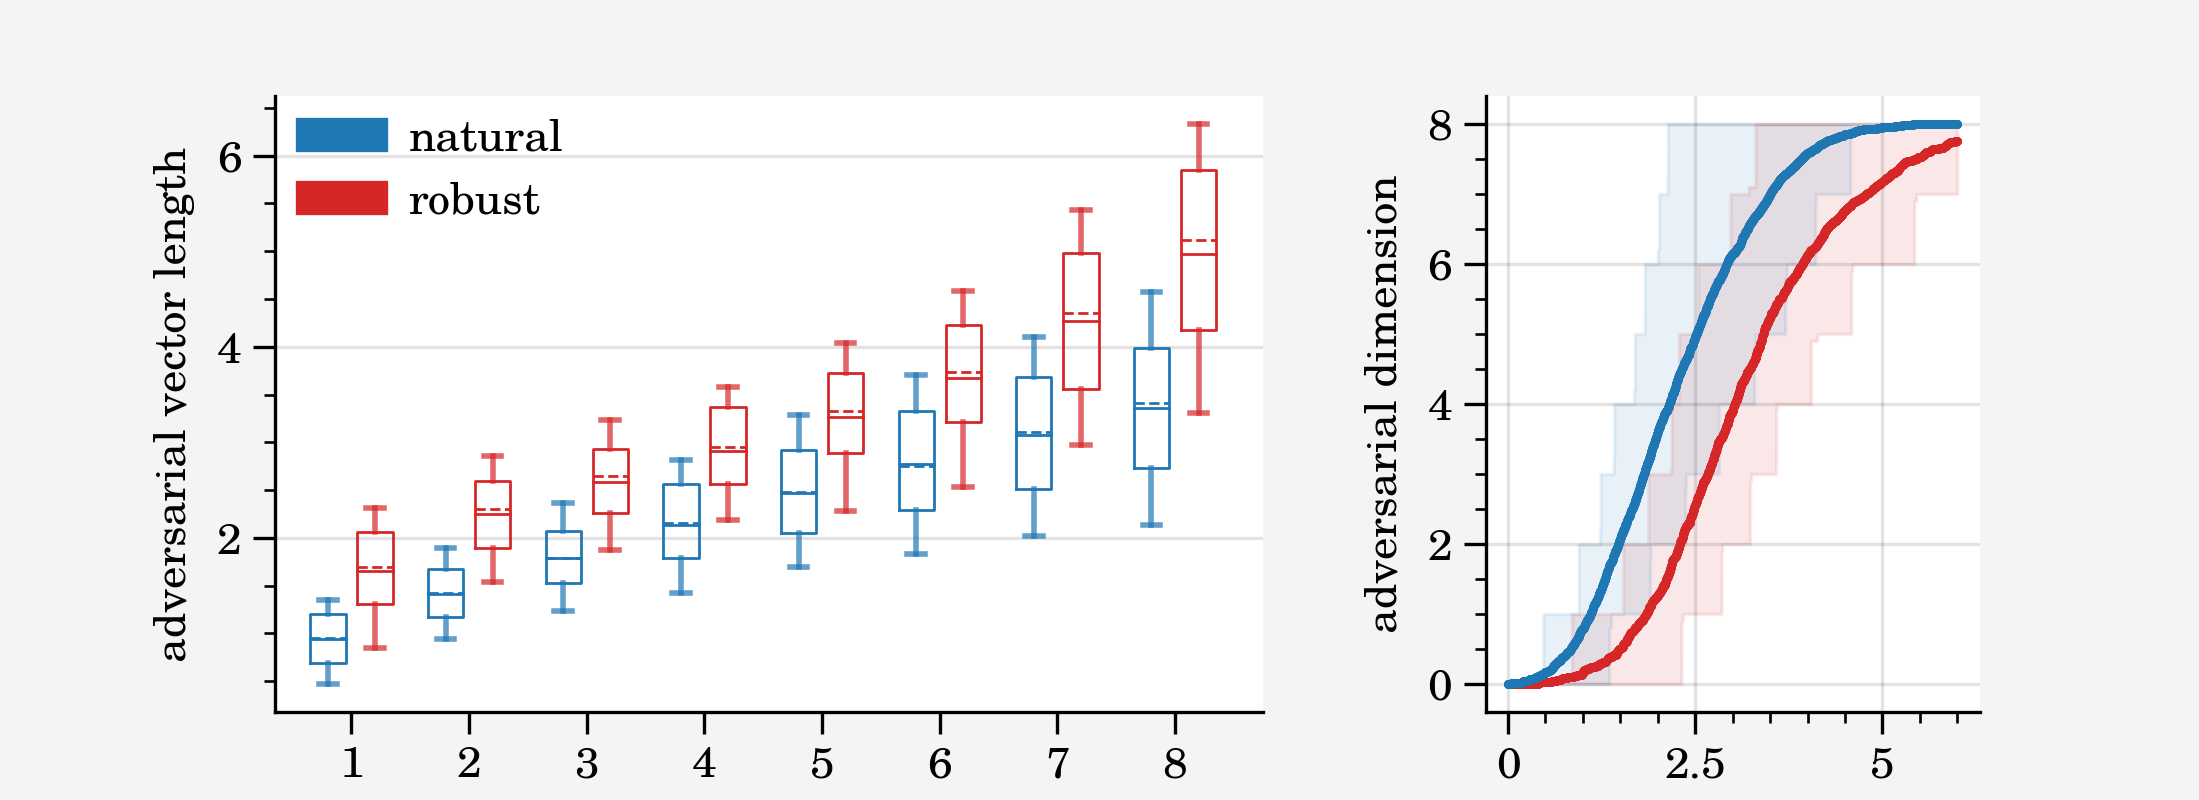

In [11]:
fig, axs = plt.subplots(1,2, figsize=(figwidth, 2), dpi=200, gridspec_kw={'width_ratios': [2,1]})
        
# plot with all adversarials included
plot_boxplot([p_natural,p_robust],  n=n_dims, labels=['natural','robust'], ax=axs[0], showmeans=True)
axs[0].set_xlim(-1.3,2*n_dims-0.5)
axs[0].set_xlabel('adversarial dimension')
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)


axs[1].plot(epsilons, means_robust,'.', markersize=1,color=plot_colors[1],  label='robust')
axs[1].fill_between(epsilons, (means_robust-errors_robust[0]), (means_robust+errors_robust[1]), color=plot_colors[1], alpha=.1)
axs[1].plot(epsilons, means_natural,'.', markersize=1, color=plot_colors[0],   label='natural')
axs[1].fill_between(epsilons, (means_natural-errors_natural[0]), (means_natural+errors_natural[1]), color=plot_colors[0], alpha=.1)
axs[1].set_ylabel('adversarial dimension')
axs[1].set_xlabel('distance to decision boundary')
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
fig.subplots_adjust(wspace=.3)


fig.savefig('../figures/mnist_pert_lengths.pdf', dpi=dpi, transparent=True, bbox_inches="tight", pad_inches=0.01)

# Distance to decision boundary

/home/bethge/dschultheiss/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning:

Mean of empty slice

/home/bethge/dschultheiss/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning:

Mean of empty slice

/home/bethge/dschultheiss/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning:

All-NaN slice encountered

/home/bethge/dschultheiss/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning:

All-NaN slice encountered



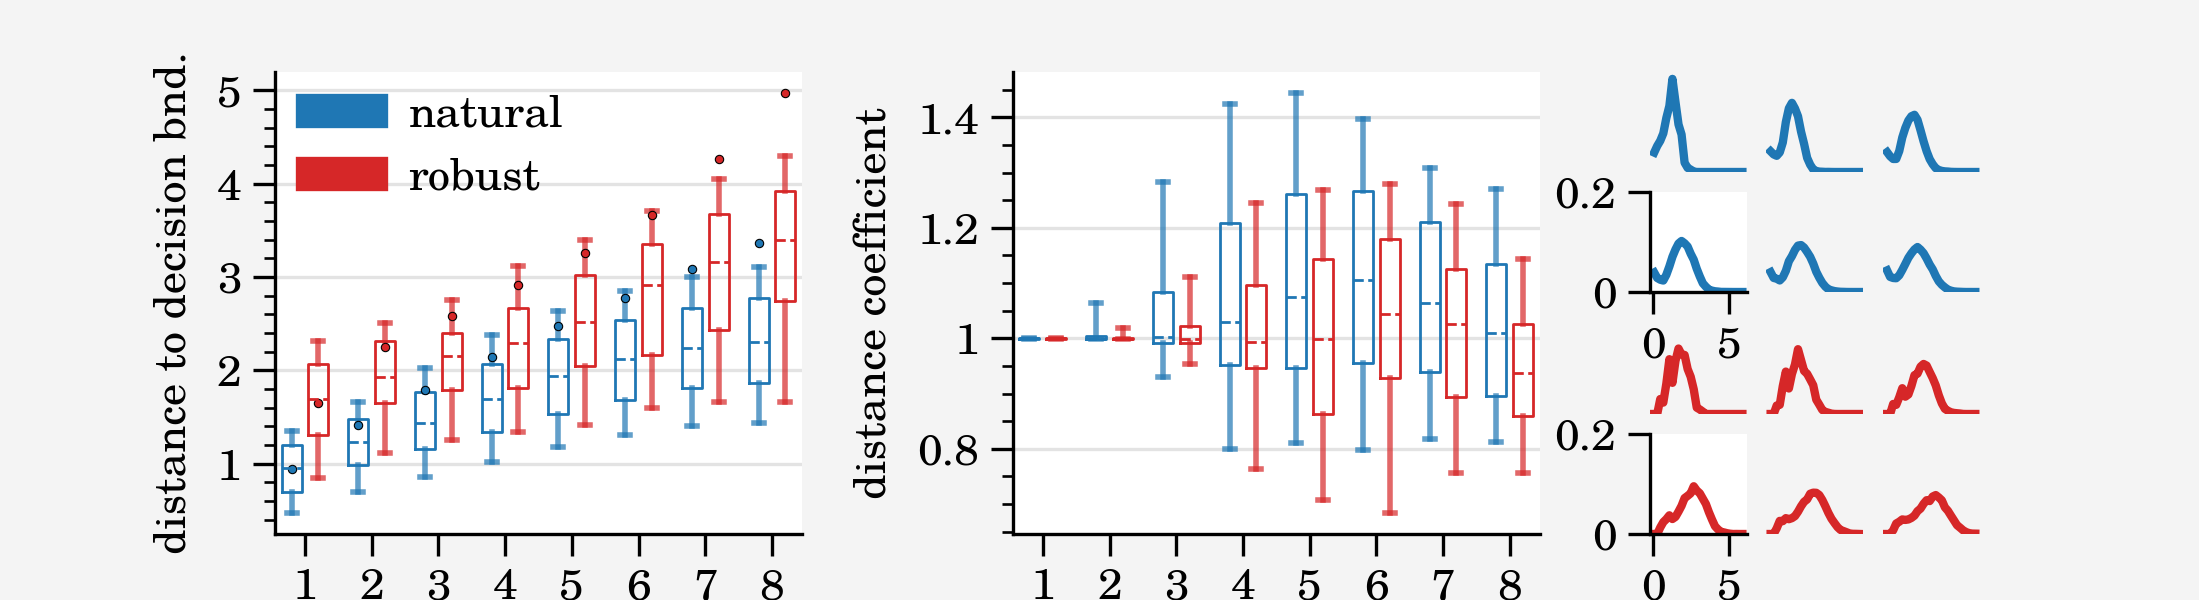

In [12]:
n_dims=8
mean_dists_natural = np.nanmean(dists_natural,axis=-1)
mean_dists_robust = np.nanmean(dists_robust,axis=-1)

max_dists_natural = np.nanmax(dists_natural,axis=-1)
max_dists_robust = np.nanmax(dists_robust,axis=-1)

dist_coeffs_natural = max_dists_natural/p_natural
dist_coeffs_robust = max_dists_robust/p_robust


fig=plt.figure(figsize=(figwidth,1.5), dpi=200)
gs1 = fig.add_gridspec(1,2, wspace=.4, right=0.7)
gs2 = fig.add_gridspec(2,1, hspace=.1, left=0.75)
gs_r1 = gs2[0].subgridspec(2, 3)
gs_r2 = gs2[1].subgridspec(2, 3)

ax1 = fig.add_subplot(gs1[0])
ax2 = fig.add_subplot(gs1[1])

plot_boxplot([mean_dists_natural,mean_dists_robust],  n=n_dims, labels=['natural','robust'], ax=ax1)
ax1.plot(np.arange(0,2*n_dims,2)+0.4,np.nanmean(p_robust, axis=0),'o',markeredgecolor='k', markeredgewidth=.2, markerfacecolor=plot_colors[1], ms=1.5)
ax1.plot(np.arange(0,2*n_dims,2)-0.4,np.nanmean(p_natural, axis=0),'o',markeredgecolor='k', markeredgewidth=.2, markerfacecolor=plot_colors[0], ms=1.5)
ax1.set_ylabel('distance to decision bnd.')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

plot_boxplot([dist_coeffs_natural,dist_coeffs_robust],  n=n_dims, ax=ax2)
fig.text(0.4, -0.07, 'dimension of adversarial space', ha='center', fontsize=8)
ax2.set_ylabel('distance coefficient')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

n_cols = 3
n_rows = 2

bins = np.arange(-0.025,6,.2)
for i in range(n_rows*n_cols):
    ax = fig.add_subplot(gs_r1[int(i/n_cols),(i%n_cols)])
    ax.set_ylim(0,.2)
    sns.histplot(x=dists_natural[:,i+1].flatten(), bins=bins, stat='probability', ax = ax, element='poly', fill=False, color=plot_colors[0])
    if i==3:
        ax.grid(False)
        ax.tick_params(axis='x', which='minor', bottom=False)
        ax.tick_params(axis='y', which='minor', left=False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_ylabel('')
    else:
        ax.set_axis_off()
    
    
    ax = fig.add_subplot(gs_r2[int(i/n_cols),(i%n_cols)])
    sns.histplot(x=dists_robust[:,i+1].flatten(), bins=bins, stat='probability', ax = ax, element='poly', fill=False, color=plot_colors[1])
    ax.set_ylim(0,.2)
    if i==3:
        ax.grid(False)
        ax.tick_params(axis='x', which='minor', bottom=False)
        ax.tick_params(axis='y', which='minor', left=False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_ylabel('')
    else:
        ax.set_axis_off()
    

plt.show()
fig.savefig('../figures/mnist_dists.pdf', dpi=dpi, transparent=True, bbox_inches="tight", pad_inches=0.01)

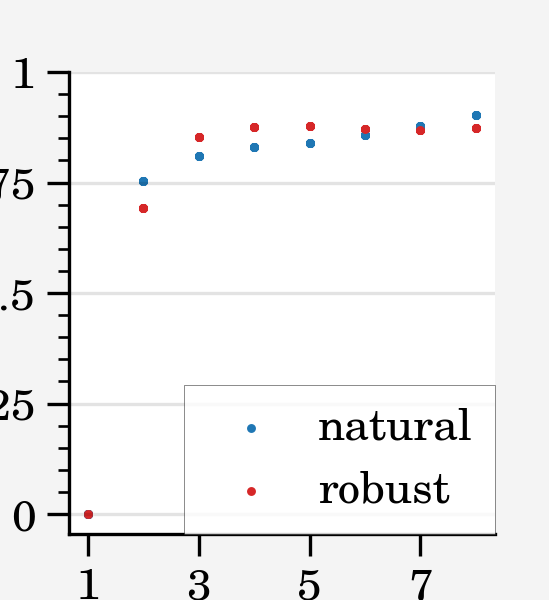

In [13]:
fig, ax = plt.subplots(figsize=(figwidth/4,1.5), dpi=200)
nans_nat = np.isnan(dists_natural).sum(-1).sum(0)/(dists_natural.shape[0]*dists_natural.shape[-1])
nans_rob = np.isnan(dists_robust).sum(-1).sum(0)/(dists_robust.shape[0]*dists_robust.shape[-1])
for dim in range(n_dims):
    ax.scatter(np.arange(1,9),nans_nat, c=plot_colors[0], s=1)
    ax.scatter(np.arange(1,9),nans_rob, c=plot_colors[1], s=1)
ax.set_xticks(np.arange(1,9,2))
ax.set_xticklabels(np.arange(1,8+1,2))
ax.tick_params(axis='x', which='minor', bottom=False)
ax.xaxis.grid(False)
ax.set_ylim(top=1)
ax.set_xlabel('dimension of adversarial sapce')
ax.set_ylabel('out of bounds ratio')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
leg = ax.legend(labels=['natural','robust'], frameon=True)
leg.get_frame().set_linewidth(0.1)
fig.savefig('../figures/mnist_bnd_ratio.pdf', dpi=dpi, transparent=True, bbox_inches="tight", pad_inches=0.01)

In [15]:
n_dims = 8
n_rows = 2
n_cols = 5

images_ = images[np.invert(np.isnan(pert_lengths)).sum(-1) >= n_dims]
labels_ = labels[np.invert(np.isnan(pert_lengths)).sum(-1) >= n_dims]
dirs_ = dirs[np.invert(np.isnan(pert_lengths)).sum(-1) >= n_dims][:,:n_dims]
advs_ = advs[np.invert(np.isnan(pert_lengths)).sum(-1) >= n_dims][:,:n_dims]
pert_lengths_ = pert_lengths[np.invert(np.isnan(pert_lengths)).sum(-1) >= n_dims][:,:n_dims]

coeffs = dists_natural[:,1:]/pert_lengths_[:,1:,None]
idcs=[]
max_coeffs = []
for i, c in enumerate(coeffs): 
    idx = np.unravel_index(np.nanargmax(coeffs[i].ravel()), coeffs[i].shape)
    max_coeffs.append(c[idx])
    idx = (idx[0]+1, idx[1])
    idcs.append((i,) + idx)
    

idcs = [idcs[idx] for idx in np.argsort(max_coeffs)]
max_coeffs = [max_coeffs[idx] for idx in np.argsort(max_coeffs)]

plt_idcs = np.linspace(10,len(idcs)-1,n_rows*n_cols) #np.arange(0,len(valid_idcs),len(valid_idcs)/(n_rows*n_cols-1))


fig, axs = plt.subplots(n_rows,n_cols, figsize=(figwidth,2), dpi=200)
for i, idx in enumerate(plt_idcs):
    img_idx=idcs[int(idx)]
    vec = largest_vecs_natural[img_idx[:-1]]
    vec_orth = vec - (vec*dirs_[img_idx[:-1]]).sum()*dirs_[img_idx[:-1]]
    vec_orth = vec_orth/np.linalg.norm(vec_orth)
    orig = images_[img_idx[0]]
    adv1 = advs_[img_idx[:-1]]
    adv2 = orig.flatten() + vec_orth*dists_natural[img_idx]
    model_ = model_natural
    plot_dec_space(orig, adv1, adv2, model_natural,n_grid=100, offset=dists_natural[img_idx]/3, arrows=[vec*dists_natural[img_idx]],
                      len_grid_scale=1.5, overlay_inbounds=True, show_legend=True,  show_advs=True, ax = axs[int(i/n_cols),(i%n_cols)])
#     axs[int(i/n_cols),(i%n_cols)].set_xlabel('coeff = %.2f' % (max_coeffs[int(idx)]), fontsize=5)
    axs[int(i/n_cols),(i%n_cols)].tick_params(axis='x', which='minor', bottom=False)
    axs[int(i/n_cols),(i%n_cols)].tick_params(axis='y', which='minor', left=False)
    axs[int(i/n_cols),(i%n_cols)].tick_params(axis='x', which='major', length=1)
    axs[int(i/n_cols),(i%n_cols)].tick_params(axis='y', which='major', length=1)
#     at = AnchoredText('%.2f' % (max_coeffs[int(idx)]),
#                       prop=dict(size=5), 
#                       frameon=True,
#                       loc='upper right')
#     at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
#     axs[int(i/n_cols),(i%n_cols)].add_artist(at)
    axs[int(i/n_cols),(i%n_cols)].text(.72, 0.83,'%.2f' % (max_coeffs[int(idx)]),transform=axs[int(i/n_cols),(i%n_cols)].transAxes,  fontsize=5, bbox= dict(facecolor='white', alpha=.5, pad=2))
    axs[int(i/n_cols),(i%n_cols)].text(.3, 0.05,'adv dir %d' % (img_idx[1]+1),transform=axs[int(i/n_cols),(i%n_cols)].transAxes,  fontsize=5)
    

colors = ['orange', 'green', 'brown', 'grey', 'blue', 'pink','cyan', 'olive', 'red', 'purple']
handles = []
for i, c in enumerate(range(10)):
    handles.append(mpatches.Patch(color=plot_colors[c], label=str(c)))
leg = fig.legend(handles=handles, loc = 'right', bbox_to_anchor=(1, .5), prop={"size":5})
leg.set_title('predicted \nclass',prop={'size':5})
fig.subplots_adjust(wspace=.2,hspace=.2, right=0.9,)
plt.show()
fig.savefig('../figures/mnist_dec_space.pdf', dpi=dpi, transparent=True, bbox_inches="tight", pad_inches=0.01)

ValueError: operands could not be broadcast together with shapes (329,7,1000) (162,7,1) 

In [197]:
def plot_dec_space(orig, adv1, adv2, model, offset=0.1, len_grid_scale=2, n_grid=100, show_legend=True, show_advs=True,
                   overlay_inbounds=False, origin_centered=False, ax=None, arrows=None):
    if ax is None:
        fig, ax = plt.subplots()
    shape = orig.shape
    orig = orig.flatten()
    pert1 = adv1 - orig
    pert2 = adv2 - orig
    len1 = np.linalg.norm(pert1)
    len2 = np.linalg.norm(pert2)
    dir1 = pert1 / len1
    dir2 = pert2 / len2

    len_grid = len_grid_scale * np.maximum(len1,len2)
    if origin_centered:
        offset=len_grid

    x = np.linspace(-offset, len_grid, n_grid)
    y = np.linspace(-offset, len_grid, n_grid)
    X, Y = np.meshgrid(x, y)
    advs = orig + (dir1[None, :] * np.reshape(X, (-1, 1)) + dir2[None, :] * np.reshape(Y, (-1, 1)))
    advs = np.array(np.reshape(advs, ((-1,) + shape)).astype('float64'))
    input = torch.split(torch.tensor(advs, device=dev()), 20)

    preds = np.empty((0, 10))
    for batch in input:
        preds = np.concatenate((preds, model(batch).detach().cpu().numpy()), axis=0)

    classes = np.argmax(preds, axis=-1).reshape((n_grid, n_grid))
    colors = ['orange', 'green', 'brown', 'grey', 'blue', 'pink','cyan', 'olive', 'red', 'purple']
    
    # Plot the surface.
    new_cmap = ListedColormap(plot_colors)

    ax.imshow(classes, cmap=new_cmap, origin='lower', vmin=0, vmax=9)
    if overlay_inbounds:
        new_cmap2 = ListedColormap(['none', 'k'])
        out_of_bounds = np.logical_or(advs.max(axis=(1,2,3))>1, advs.min(axis=(1,2,3))<0).reshape((n_grid, n_grid))
        ax.imshow(out_of_bounds, cmap=new_cmap2, origin='lower', alpha=.5, vmin=0, vmax=1)

    ax.axvline(offset*n_grid/(offset+len_grid), c='k', ls='--', alpha=0.5, linewidth=.5)
    ax.axhline(offset*n_grid/(offset+len_grid), c='k', ls='--', alpha=0.5, linewidth=.5)

    ax.plot(offset*n_grid/(offset+len_grid), offset*n_grid/(offset+len_grid),
             markeredgecolor='black', markerfacecolor='black', marker='o', markersize=1.5, markeredgewidth=.2)
    
    if not arrows is None:
        arrow_width = 0.0
        arrow_linewidth = 1
        arrow_headsize = 3
        arrow_head_length = 3
        arrow_head_width = 3
        for arrow in arrows:
            arr_x = (dir1* arrow).sum()
            arr_y = (dir2 * arrow).sum()
            vect_x = (arr_x) * n_grid / (offset + len_grid)
            vect_y = (arr_y) * n_grid / (offset + len_grid)
            ax.arrow(offset*n_grid/(offset+len_grid), offset*n_grid/(offset+len_grid), vect_x, vect_y,
                width=arrow_width, head_width=arrow_head_width, head_length=arrow_head_length,
                fc='k', ec='k', linestyle='-', linewidth=arrow_linewidth, length_includes_head=True)

    if show_advs:
        adv_locs = [
            [
                offset * n_grid / (offset + len_grid),
                (offset + len1) * n_grid / (offset + len_grid)
            ],[
                (offset + len2) * n_grid / (offset + len_grid),
                offset * n_grid / (offset + len_grid)
            ]
        ]
        ax.plot(adv_locs[0][1], adv_locs[0][0],
                 markeredgecolor='black', markerfacecolor='red', marker='o', markersize=1.5, markeredgewidth=.2)
#         ax.plot(adv_locs[1][1], adv_locs[1][0],
#                  markeredgecolor='black', markerfacecolor='red', marker='o')


    data_ticks = np.linspace(offset*n_grid/(offset+len_grid), (offset+0.9*len_grid)*n_grid/(offset+len_grid), 3)
    plot_ticks = [np.round(x, 2).astype(str) for x in np.linspace(0, 0.9*len_grid, 3)]
    ax.set_xticks(data_ticks, minor=False)
    ax.set_xticklabels(plot_ticks, fontsize=4)
    ax.set_yticks(data_ticks, minor=False)
    ax.set_yticklabels(plot_ticks, fontsize=4)

    
    if ax is None:
        return fig, ax, advs, labels
    else:
        return advs, labels

# Accuracy table

In [26]:
epsilons = [0,.5,1,2,4,6]
n_dims = 10
all_accs = [epsilons]

accs_nat = []
accs_rob = []
for d in range(n_dims):
    pl_nat = pert_lengths[np.invert(np.isnan(pert_lengths)).sum(-1)>=d,d]
    pl_rob = pert_lengths_madry[np.invert(np.isnan(pert_lengths_madry)).sum(-1)>=d,d]
    n_nat = len(pl_nat)
    n_rob = len(pl_rob)
    accs= np.zeros((len(epsilons),2))
    for i, e in enumerate(epsilons):
        accs[i,0] = .9859 - ((pl_nat<=e).sum()/n_nat*.9859)
        accs[i,1] = .9856 - ((pl_rob<=e).sum()/n_rob*.9856)   
    accs=np.around(accs*100,2)
    accs_nat.append([str(a[0]) + '\% /' for a in accs])
    accs_rob.append([str(a[1]) + '\%' for a in accs])

In [33]:
for i in range(0,len(accs_nat[0])):
    long_s_nat = str(epsilons[i])
    long_s_rob = ''
    for s_nat, s_rob in zip(np.array(accs_nat)[:,i],np.array(accs_rob)[:,i]) :
        long_s_nat +=  ' & ' + s_nat 
        long_s_rob += ' & ' + s_rob
    print(long_s_nat + ' \\\\')
    print(long_s_rob + ' \\\\[.2cm]')

0 & 98.59\% / & 98.59\% / & 98.59\% / & 98.59\% / & 98.59\% / & 98.59\% / & 98.59\% / & 98.59\% / & 98.59\% / & 98.59\% / \\
 & 98.56\% & 98.56\% & 98.56\% & 98.56\% & 98.56\% & 98.56\% & 98.56\% & 98.56\% & 98.56\% & 98.56\% \\[.2cm]
0.5 & 90.51\% / & 97.41\% / & 98.0\% / & 98.39\% / & 98.39\% / & 98.39\% / & 98.37\% / & 98.35\% / & 98.29\% / & 98.23\% / \\
 & 97.77\% & 98.56\% & 98.56\% & 98.56\% & 98.56\% & 98.56\% & 98.56\% & 98.56\% & 98.56\% & 98.56\% \\[.2cm]
1 & 60.53\% / & 90.31\% / & 95.83\% / & 97.01\% / & 97.4\% / & 97.58\% / & 97.94\% / & 97.86\% / & 97.69\% / & 97.51\% / \\
 & 94.03\% & 98.36\% & 98.56\% & 98.56\% & 98.56\% & 98.56\% & 98.56\% & 98.56\% & 98.56\% & 98.56\% \\[.2cm]
2 & 1.77\% / & 18.34\% / & 47.91\% / & 71.58\% / & 83.54\% / & 88.51\% / & 91.63\% / & 93.0\% / & 93.8\% / & 93.55\% / \\
 & 68.99\% & 89.3\% & 95.01\% & 96.59\% & 97.57\% & 97.69\% & 97.73\% & 97.72\% & 98.56\% & 98.56\% \\[.2cm]
4 & 0.0\% / & 0.0\% / & 0.2\% / & 4.14\% / & 15.05\% / & 26.41\%